# NLP Week 4 Shakespeare Exercise

* [Google Colab Notebook](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP_Week4_Exercise_Shakespeare_Question.ipynb)

* [Solution Notebook](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP_Week4_Exercise_Shakespeare_Answer.ipynb)

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
""" The original Notebook has a lot of this in a single cell. I like to break it up - especially the download and loading. """
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O ./sonnets.txt

data = open('sonnets.txt').read()
corpus = data.lower().split("\n")

--2020-12-21 10:18:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
wget: /Users/carlos/.netrc:2: warning: ‘login’ token appears before any machine name
wget: /Users/carlos/.netrc:3: warning: ‘password’ token appears before any machine name
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.16, 172.217.1.208, 172.217.2.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘./sonnets.txt’

./sonnets.txt       100%[===================>]  91.38K  --.-KB/s    in 0.08s   

2020-12-21 10:18:38 (1.12 MB/s) - ‘./sonnets.txt’ saved [93578/93578]



In [3]:
""" Preprocess

1. Tokenize
2. Turn texts to sequences
3. Pad sequences (using padding='pre' since the last characters are the label)
4. Get the predictors
5. Get the labels
6. Turn the labels to a categorical dictionary (essentially vectorizing)
"""
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

## Define the Model

* My initial definition with arbitrary values was way off. I had an accuracy of 1%...

```python
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(
    16,
    activation='relu',
    kernel_regularizer='l1',
    bias_regularizer='l1',
    activity_regularizer='l1'
))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())
```

* After reading more about Regularizers, I realized I didn't need all 3 - kernel, bias and activity

In [5]:
""" Define and Compile the model """
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(
    total_words / 2,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01),
))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [6]:
history = model.fit(
    predictors,
    label,
    epochs=100,
    verbose=1
)

Epoch 1/100
484/484 [==============================] - 19s 39ms/step - loss: 6.9102 - accuracy: 0.0209
Epoch 2/100
484/484 [==============================] - 18s 36ms/step - loss: 6.5003 - accuracy: 0.0245
Epoch 3/100
484/484 [==============================] - 19s 40ms/step - loss: 6.3861 - accuracy: 0.0270
Epoch 4/100
484/484 [==============================] - 17s 36ms/step - loss: 6.2706 - accuracy: 0.0312
Epoch 5/100
484/484 [==============================] - 18s 37ms/step - loss: 6.1885 - accuracy: 0.0343
Epoch 6/100
484/484 [==============================] - 18s 37ms/step - loss: 6.1181 - accuracy: 0.0371
Epoch 7/100
484/484 [==============================] - 18s 37ms/step - loss: 6.0509 - accuracy: 0.0398
Epoch 8/100
484/484 [==============================] - 18s 38ms/step - loss: 5.9900 - accuracy: 0.0423
Epoch 9/100
484/484 [==============================] - 19s 38ms/step - loss: 5.9200 - accuracy: 0.0460
Epoch 10/100
484/484 [==============================] - 18s 37ms/step - l

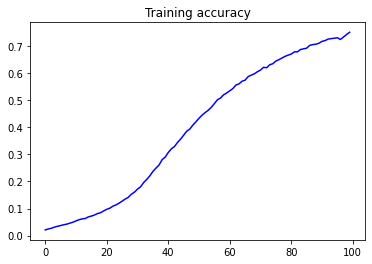

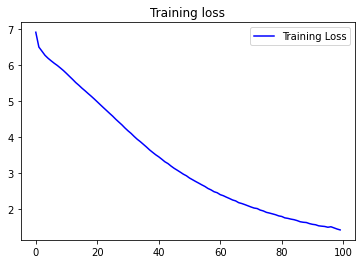

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0) # deprecated - use line below
    # predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope that honour set so days of a tomb your state still lend be hide my true love out when it well some point so life every part still leave me that past slain thought fair ' dost writ say thee so said not kill me be alone still be call be bold stay or make so bright end give rolling seen loving eye still still rare or show your worth must betray tend one hate sounds ' are go end more than seem false live well mine eye and love some prone more light fight rare grow near care out
